<a href="https://colab.research.google.com/github/warwavn/AI-SUT2025/blob/main/D12%20Transfer%20Learning/D12_Assignment_ball_screw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

N = Normal, P = Pitting

split train, test & set class

In [3]:
!gdown 1lhvQAKJCV3uwD34YYbtIOaH-FErep32O

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1lhvQAKJCV3uwD34YYbtIOaH-FErep32O

but Gdown can't. Please check connections and permissions.


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile(r"/content/ball_screw_dataset.zip","r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths to the folder with images
source_folder = '/content/ball_screw_dataset'  # Folder containing all images
train = '/content/ball_screw_dataset/train'
test = '/content/ball_screw_dataset/test'

# Create train/test folders if they don't exist
os.makedirs(train, exist_ok=True)
os.makedirs(test, exist_ok=True)

# Create subfolders for the classes in train and test
os.makedirs(os.path.join(train, 'normal'), exist_ok=True)
os.makedirs(os.path.join(train, 'pitting'), exist_ok=True)
os.makedirs(os.path.join(test, 'normal'), exist_ok=True)
os.makedirs(os.path.join(test, 'pitting'), exist_ok=True)

# List all images in the source folder
images = os.listdir(source_folder)

# Create a list to store images and their labels (0 for normal, 1 for pitting)
image_labels = []
for img in images:
    if img.endswith('.jpg') or img.endswith('.png'):  # or any other image format
        # Check the first letter of the filename for labeling
        label = 0 if img.startswith('N') else 1  # 'N' = normal, 'P' = pitting
        image_labels.append((img, label))

# Split into train and test sets (80% train, 20% test)
train_images, test_images = train_test_split(image_labels, test_size=0.2, random_state=42)

# Move train images to the appropriate folder
for img, label in train_images:
    src = os.path.join(source_folder, img)
    if label == 0:
        shutil.move(src, os.path.join(train, 'normal', img))
    else:
        shutil.move(src, os.path.join(train, 'pitting', img))

# Move test images to the appropriate folder
for img, label in test_images:
    src = os.path.join(source_folder, img)
    if label == 0:
        shutil.move(src, os.path.join(test, 'normal', img))
    else:
        shutil.move(src, os.path.join(test, 'pitting', img))

print(f"Training set has {len(train_images)} images.")
print(f"Test set has {len(test_images)} images.")


Training set has 17468 images.
Test set has 4367 images.


In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255,validation_split = 0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255)

In [ ]:
train_dir = "/content/ball_screw_dataset/train"
test_dir = "/content/ball_screw_dataset/test"
bs = 32

tf.random.set_seed(42)
train_data = train_datagen.flow_from_directory(train_dir , batch_size = bs,target_size = (224,224),
                                               class_mode = 'binary',
                                               subset = 'training')
val_data = train_datagen.flow_from_directory(train_dir , batch_size = bs,target_size = (224,224),
                                               class_mode = 'binary',
                                               subset = 'validation')
test_data = test_datagen.flow_from_directory(test_dir, batch_size = bs,target_size = (224,224),
                                               class_mode = 'binary')

Found 13975 images belonging to 2 classes.
Found 3493 images belonging to 2 classes.
Found 4367 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0

In [ ]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet',include_top=False,input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = tf.keras.models.Sequential()

model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())                #increase model generalize, reduce overfitting

#Prediction layer

# model.add(tf.keras.layers.Dense(256,activation = "relu"))
model.add(tf.keras.layers.Dense(128,activation = "relu"))
# model.add(tf.keras.layers.Dense(68,activation = "sigmoid"))
model.add(tf.keras.layers.Dense(1,activation = "sigmoid"))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,444,101 (272.54 MB)

 Trainable params: 23,796,993 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,593,988 (181.56 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler

In [ ]:
es_callback = EarlyStopping(
    monitor = 'val_loss',               #acc, prec, rec
    patience = 10,                       #waiting not immidiately stop in case of swing
    restore_best_weights = True,        #return
    verbose = 1                         #what is that?
)

In [ ]:
def lr_scheduler(epoch,lr):
  return lr*0.95

lr_callback = LearningRateScheduler(lr_scheduler)

In [ ]:
import numpy as np
print(np.unique(train_data.classes, return_counts=True))

(array([0, 1], dtype=int32), array([7105, 6870]))


In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(0.001),
              metrics= ['accuracy','precision','recall'])

In [ ]:
hist = model.fit(train_data, epochs = 30, batch_size = 32,
                 validation_data = val_data,
                 callbacks = [es_callback, lr_callback])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 241s 382ms/step - accuracy: 0.9247 - loss: 0.2082 - precision: 0.9338 - recall: 0.9136 - val_accuracy: 0.5084 - val_loss: 1.1616 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 9.5000e-04
Epoch 2/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 135s 308ms/step - accuracy: 0.9814 - loss: 0.0553 - precision: 0.9807 - recall: 0.9813 - val_accuracy: 0.8291 - val_loss: 0.4695 - val_precision: 0.8402 - val_recall: 0.8055 - learning_rate: 9.0250e-04
Epoch 3/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 135s 308ms/step - accuracy: 0.9871 - loss: 0.0384 - precision: 0.9872 - recall: 0.9867 - val_accuracy: 0.9528 - val_loss: 0.1691 - val_precision: 0.9330 - val_recall: 0.9738 - learning_rate: 8.5737e-04
Epoch 4/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 142s 308ms/step - accuracy: 0.9909 - loss: 0.0254 - precision: 0.9894 - recall: 0.9921 - val_accuracy: 0.9656 - val_loss: 0.1397 - val_precision: 0.9390 - val_recall: 0.9948 - learning_rate: 8.1451e-04
Epoch 5/30
437/437 ━━━━━

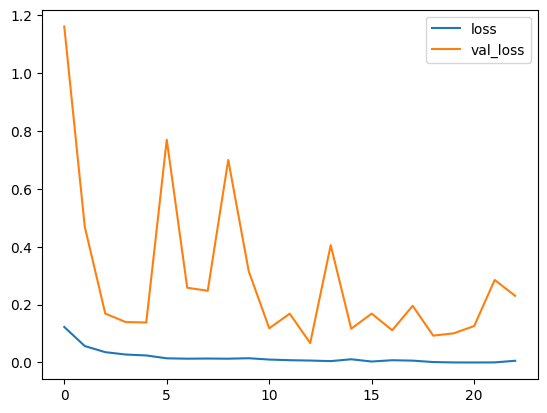

In [ ]:
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.legend()

In [ ]:
model.save("D12 ball screw.keras")

In [ ]:
train_data.class_indices

{'normal': 0, 'pitting': 1}

In [ ]:
from tensorflow.keras.preprocessing import image
import os
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# class_names = ['normal','pitting']
# y_true = []
# y_pred = []
# y_scores = []
# for class_name in class_names:
#   class_folder = os.path.join(test_dir,class_name)
#   for img_name in os.listdir(class_folder):
#     img_path = os.path.join(class_folder, img_name)
#     img = image.load_img(img_path, target_size = (224,224))
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis = 0)
#     img_array /= 255.0
#     res = model.predict(img_array).flatten()[0]

#     if res > 0.5:
#       pred_class = 1
#     else:
#       pred_class = 0

#     actual_class = class_names.index(class_name)
#     y_scores.append(res)
#     y_pred.append(pred_class)
#     y_true.append(actual_class)

# accuracy = accuracy_score(y_true,y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

In [ ]:

class_names = ['normal', 'pitting']
y_true = []
y_pred = []
y_scores = []

# Set batch size to control the memory usage (you can adjust this number as needed)
batch_size = 32

In [ ]:
# Process the images in chunks
for class_name in class_names:
    class_folder = os.path.join(test_dir, class_name)

    # Initialize a temporary list to hold images and actual labels for this batch
    batch_images = []
    batch_labels = []

    # Loop through the images in the class folder
    for img_idx, img_name in enumerate(os.listdir(class_folder)):
        img_path = os.path.join(class_folder, img_name)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Append the processed image and its label to the batch
        batch_images.append(img_array)
        batch_labels.append(class_names.index(class_name))

        # When the batch is full, make predictions and process the batch
        if len(batch_images) == batch_size or (img_idx == len(os.listdir(class_folder)) - 1):  # Last batch
            batch_images = np.vstack(batch_images)  # Convert the list to a numpy array

            # Make predictions on the batch
            batch_preds = model.predict(batch_images).flatten()

            # Iterate through the predictions and append results to the lists
            for i, res in enumerate(batch_preds):
                pred_class = 1 if res > 0.5 else 0
                actual_class = batch_labels[i]
                y_scores.append(res)
                y_pred.append(pred_class)
                y_true.append(actual_class)

            # Reset the batch lists
            batch_images = []
            batch_labels = []

    print(f"Finished processing class: {class_name}")

# Calculate accuracy after processing all images
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
plt.figure(figsize=(12, 5))

# Plot for Anomaly (Class 0)
plt.subplot(1, 2, 1)
sns.histplot(np.array(y_scores)[np.array(y_true) == 0], bins=50, kde=True, color='red', alpha=0.6)
# plt.axvline(x=0.5, color='black', linestyle='dashed', label="Threshold (0.5)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Anomaly (Class 0) Predictions")
plt.legend()

# Plot for Normal (Class 1)
plt.subplot(1, 2, 2)
sns.histplot(np.array(y_scores)[np.array(y_true) == 1], bins=50, kde=True, color='blue', alpha=0.6)
# plt.axvline(x=0.5, color='black', linestyle='dashed', label="Threshold (0.5)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Normal (Class 1) Predictions")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(f"Test Accuracy is: {accuracy}")

Test Accuracy is: 0.9894664529425234


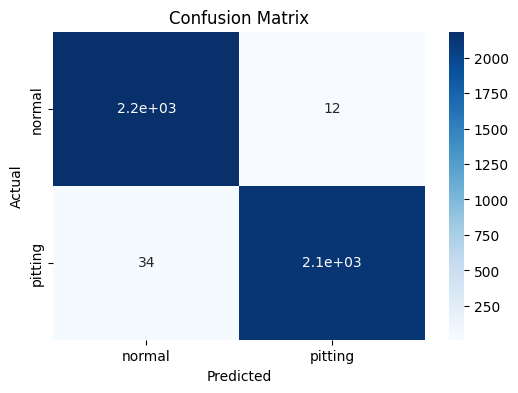

In [ ]:
from sklearn.metrics import confusion_matrix
cmfx = confusion_matrix(y_true,y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cmfx, annot=True, cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

# Customize the plot
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# from pathlib import Path
# from sklearn.metrics import accuracy_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Paths and class labels
# test_dir = Path("/content/prepared_ball_screw_dataset/test")
# class_names = ['n', 'p']
# batch_size = 32  # Adjust based on available memory

# # Collect all image paths and true labels
# image_paths = []
# y_true = []

# for class_name in class_names:
#     class_folder = test_dir / class_name
#     for img_name in os.listdir(class_folder):
#         image_paths.append(class_folder / img_name)
#         y_true.append(class_names.index(class_name))

# # Function to load and preprocess a batch of images
# def load_images(paths):
#     batch_images = []
#     for img_path in paths:
#         img = image.load_img(img_path, target_size=(224, 224))
#         img_array = image.img_to_array(img) / 255.0  # Normalize
#         batch_images.append(img_array)
#     return np.array(batch_images)

# # Perform batch predictions
# y_pred = []
# for i in range(0, len(image_paths), batch_size):
#     batch_paths = image_paths[i:i + batch_size]
#     batch_images = load_images(batch_paths)
#     batch_preds = model.predict(batch_images, verbose=0).flatten()
#     batch_classes = (batch_preds > 0.5).astype(int)
#     y_pred.extend(batch_classes)

# # Compute accuracy and confusion matrix
# accuracy = accuracy_score(y_true, y_pred)
# print(f"Test Accuracy: {accuracy:.4f}")

# cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# plt.show()